In [1]:
cd /home/lansdell/projects/synthfeedback/

/home/lansdell/projects/synthfeedback


In [2]:
%pylab inline
from models.npmodels import AENPModel5_ADAM, AENPModel5_ExactLsq_BPAuto, AENPModel5_ExactLsq_FAAuto, AENPModel5, AENPModel5_DAE
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from numpy import random as rng
import seaborn as sns
import pickle
import argparse
import pandas as pd 
import pickle
sns.set_style('ticks')

from data_loader.data_generator import MNISTDataGenerator
from trainers.sf_trainer import AESFTrainer
from utilities.config import process_config
from utilities.logger import LoggerNumpy, Logger

Populating the interactive namespace from numpy and matplotlib


/home/lansdell/conda-envs/py34local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lansdell/conda-envs/py34local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lansdell/conda-envs/py34local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lansdell/conda-envs/py34local/lib/pyt

In [3]:
def smooth(y, box_pts=50):
    box = np.ones(box_pts)/box_pts
    if len(y.shape) == 2:
        y_smooth = y.copy()
        for i in range(y.shape[0]):
            y_smooth[i,:] = np.convolve(y[i,:], box, mode='same')
    else:
        y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

## Plot all on same curve

### Load data

In [4]:
test_idx = 2; # train loss
train_idx = 0; # test loss

#Load DAE data from script
model = 'nodepert_ae5_dae_convparams'
fn_in = './experiments/%s/summary/3_autoencoder_correctbatch.npz'%model
#fn_in = './experiments/%s/summary/3_autoencoder.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
train_loss_DAE = metrics[0,:,:,train_idx]
loss_DAE = metrics[0,:,:,test_idx]

#Load BP data from script
model = 'bpauto'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
#fn_in = './experiments/nodepert_ae5_bpauto/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
train_loss_BP = metrics[0,:,:,train_idx]
loss_BP = metrics[0,:,:,test_idx]
print('backprop data', metrics.shape)

#Load FA data
model = 'faself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
#fn_in = './experiments/nodepert_ae5_faauto/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
train_loss_FA = metrics[0,:,:,train_idx]
loss_FA = metrics[0,:,:,test_idx]
print('FA data', metrics.shape)

#Load Adam data
model = 'adam'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder_correctbatch.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
train_loss_AD = metrics[0,:,:,train_idx]
loss_AD = metrics[0,:,:,test_idx]
print('AD data', metrics.shape)

## load the NP data
model = 'sgd_convparams'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder_correctbatch.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
print('NP data', metrics.shape)
train_loss_NP = metrics[0,:,:,train_idx]
loss_NP = metrics[0,:,:,test_idx]

backprop data (1, 3, 1001, 13)
FA data (1, 3, 1001, 13)
AD data (1, 3, 1001, 13)
NP data (1, 3, 1001, 13)


In [5]:
## load the matched data
fn_in = './experiments/nodepert_ae5_matched_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
train_loss_MA = metrics[0,:,:,train_idx]
loss_MA = metrics[0,:,:,test_idx]
print('MA data', metrics.shape)

MA data (1, 3, 351, 13)


In [11]:
## load the synthgrad data
fn_in = './experiments/nodepert_ae5_synthgrad_convparams/summary/3_autoencoder_correctbatch.npz'

#data = np.load(fn_in)
with open(fn_in, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
tags = data['tags']
metrics = data['metrics']
train_loss_SG = metrics[0,:,:,train_idx]
loss_SG = metrics[0,:,:,test_idx]
print('SG data', metrics.shape)

SG data (1, 3, 1001, 13)


In [6]:
## Load BP w noise
fn_in = './experiments/nodepert_ae5_bpauto_noise/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
tags = data['tags']
metrics = data['metrics']
train_loss_BPN = metrics[0,:,:,train_idx]
loss_BPN = metrics[0,:,:,test_idx]
print('BPN data', metrics.shape)

## Load FA w noise (Still running...)
fn_in = './experiments/nodepert_ae5_faauto_noise/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
tags = data['tags']
metrics = data['metrics']
train_loss_FAN = metrics[0,:,:,train_idx]
loss_FAN = metrics[0,:,:,test_idx]
print('FAN data', metrics.shape)

BPN data (1, 3, 1001, 13)
FAN data (1, 3, 1001, 13)


In [9]:
## Load ADAM w noise
fn_in = './experiments/nodepert_ae5_adam_noise/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
tags = data['tags']
metrics = data['metrics']
train_loss_ADN = metrics[0,:,:,train_idx]
loss_ADN = metrics[0,:,:,test_idx]
print('ADN data', metrics.shape)

## Load Matched w noise
fn_in = './experiments/nodepert_ae5_matched_noise/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
tags = data['tags']
metrics = data['metrics']
train_loss_MAN = metrics[0,:,:,train_idx]
loss_MAN = metrics[0,:,:,test_idx]
print('MAN data', metrics.shape)

ADN data (1, 3, 1001, 13)
MAN data (1, 3, 1001, 13)


### Plot

AttributeError: module 'seaborn' has no attribute 'tsplot'

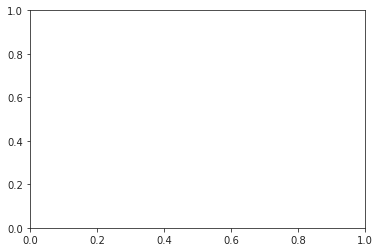

In [8]:
fig,axes = plt.subplots(1,1,figsize=(6,4))

bsize = 15
bsize1 = 250

sns.tsplot(smooth(train_loss_BP, bsize), ax = axes, color='C0')
sns.tsplot(smooth(train_loss_FA, bsize), ax = axes, color='C1')
sns.tsplot(smooth(train_loss_NP, bsize), ax = axes, color='C2')
sns.tsplot(smooth(train_loss_AD, bsize), ax = axes, color='C3')
sns.tsplot(smooth(train_loss_MA, bsize1), ax = axes, color='orange')
sns.tsplot(smooth(train_loss_DAE, bsize), ax = axes, color='black')
sns.tsplot(smooth(train_loss_SG, bsize), ax = axes, color='grey')
sns.tsplot(smooth(loss_BP, bsize), ax = axes, color='C0')
sns.tsplot(smooth(loss_FA, bsize), ax = axes, color='C1')
sns.tsplot(smooth(loss_NP, bsize), ax = axes, color='C2')
sns.tsplot(smooth(loss_AD, bsize), ax = axes, color='C3')
sns.tsplot(smooth(loss_MA, bsize1), ax = axes, color='orange')
sns.tsplot(smooth(loss_DAE, bsize), ax = axes, color='black')
sns.tsplot(smooth(loss_SG, bsize), ax = axes, color='grey')

[axes.lines[i].set_linestyle("--") for i in range(5)]

axes.legend(['backpropagation', 'feedback alignment', 'node perturbation', 'ADAM', 'matched', 'DAE', 'SG'])
axes.set_xlabel('iteration');
axes.set_ylim([450, 1000])
axes.set_ylabel('loss')
axes.set_title('train loss')

sns.despine(trim=True)
#plt.savefig('./figures/3_autoencoder_losses.pdf')

### Ablation study. What is the effect of noise?

In [12]:
## Take the lowest loss for each method of interest....
print("Mean Min test loss BP: %f"%np.mean(np.min(loss_BP,1)))
print("Mean Min test loss FA: %f"%np.mean(np.min(loss_FA,1)))
print("Mean Min test loss NP: %f"%np.mean(np.min(loss_NP,1)))
print("Mean Min test loss DAE: %f"%np.mean(np.min(loss_DAE,1)))
print("Mean Min test loss SG: %f"%np.mean(np.min(loss_SG,1)))
print("Mean Min test loss BPN: %f"%np.mean(np.min(loss_BPN,1)))
print("Mean Min test loss FAN: %f"%np.mean(np.min(loss_FAN,1)))

print("Mean Min test loss MA: %f"%np.mean(np.min(loss_MA,1)))
print("Mean Min test loss MAN: %f"%np.mean(np.min(loss_MAN,1)))
print("Mean Min test loss AD: %f"%np.mean(np.min(loss_AD,1)))
print("Mean Min test loss ADN: %f"%np.mean(np.min(loss_ADN,1)))

print("Std Min test loss BP: %f"%np.std(np.min(loss_BP,1)))
print("Std Min test loss FA: %f"%np.std(np.min(loss_FA,1)))
print("Std Min test loss NP: %f"%np.std(np.min(loss_NP,1)))
print("Std Min test loss DAE: %f"%np.std(np.min(loss_DAE,1)))
print("Std Min test loss SG: %f"%np.std(np.min(loss_SG,1)))
print("Std Min test loss BPN: %f"%np.std(np.min(loss_BPN,1)))
print("Std Min test loss FAN: %f"%np.std(np.min(loss_FAN,1)))

print("N BP: %f"%loss_BP.shape[0])
print("N FA: %f"%loss_FA.shape[0])
print("N NP: %f"%loss_BP.shape[0])
print("N DAE: %f"%loss_DAE.shape[0])
print("N SG: %f"%loss_SG.shape[0])
print("N BPN: %f"%loss_BPN.shape[0])
print("N FAN: %f"%loss_FAN.shape[0])

print("Std Err Min test loss BP: %f"%(np.std(np.min(loss_BP,1))/np.sqrt(loss_BP.shape[0])))
print("Std Err Min test loss FA: %f"%(np.std(np.min(loss_FA,1))/np.sqrt(loss_FA.shape[0])))
print("Std Err Min test loss NP: %f"%(np.std(np.min(loss_NP,1))/np.sqrt(loss_NP.shape[0])))
print("Std Err Min test loss DAE: %f"%(np.std(np.min(loss_DAE,1))/np.sqrt(loss_DAE.shape[0])))
print("Std Err Min test loss BPN: %f"%(np.std(np.min(loss_BPN,1))/np.sqrt(loss_BPN.shape[0])))
print("Std Err Min test loss FAN: %f"%(np.std(np.min(loss_FAN,1))/np.sqrt(loss_FAN.shape[0])))
print("Std Err Min test loss SG: %f"%(np.std(np.min(loss_SG,1))/np.sqrt(loss_SG.shape[0])))
print("Std Err Min test loss MA: %f"%(np.std(np.min(loss_MA,1))/np.sqrt(loss_MA.shape[0])))
print("Std Err Min test loss MAN: %f"%(np.std(np.min(loss_MAN,1))/np.sqrt(loss_MAN.shape[0])))
print("Std Err Min test loss AD: %f"%(np.std(np.min(loss_AD,1))/np.sqrt(loss_AD.shape[0])))
print("Std Err Min test loss ADN: %f"%(np.std(np.min(loss_ADN,1))/np.sqrt(loss_ADN.shape[0])))

Mean Min test loss BP: 609.841248
Mean Min test loss FA: 759.166036
Mean Min test loss NP: 515.296804
Mean Min test loss DAE: 539.821826
Mean Min test loss SG: 512.728831
Mean Min test loss BPN: 536.808960
Mean Min test loss FAN: 768.171122
Mean Min test loss MA: 643.383484
Mean Min test loss MAN: 625.232727
Mean Min test loss AD: 538.245829
Mean Min test loss ADN: 522.253011
Std Min test loss BP: 24.860951
Std Min test loss FA: 5.692929
Std Min test loss NP: 7.112625
Std Min test loss DAE: 15.493911
Std Min test loss SG: 8.349679
Std Min test loss BPN: 3.561361
Std Min test loss FAN: 4.667415
N BP: 3.000000
N FA: 3.000000
N NP: 3.000000
N DAE: 10.000000
N SG: 3.000000
N BPN: 3.000000
N FAN: 3.000000
Std Err Min test loss BP: 14.353477
Std Err Min test loss FA: 3.286814
Std Err Min test loss NP: 4.106476
Std Err Min test loss DAE: 4.899605
Std Err Min test loss BPN: 2.056153
Std Err Min test loss FAN: 2.694733
Std Err Min test loss SG: 4.820689
Std Err Min test loss MA: 5.376416
Std Er

## Images of latent space

In [6]:
def plot_bottleneck(Model = AENPModel5_ADAM, model_name = 'nodepert_ae5_adam', ax = None, cb = None):
    Data = MNISTDataGenerator
    Trainer = AESFTrainer
    config = process_config('./configs/np.json', model_name)
    tf.reset_default_graph()
    model = Model(config)
    data = Data(config)
    sess = tf.Session()
    logger = LoggerNumpy(sess, config, model)
    trainer = Trainer(sess, model, data, config, logger)
    model.load(sess)
    N = 100
    bottlenecks = np.zeros((2, config.batch_size, N))
    ys = np.zeros((config.batch_size, N))
    #Make something to load in an image, evaluate the bottleneck layer with it
    for idx in range(N):
        batch_x, batch_y = next(data.next_batch(config.batch_size))
        feed_dict = {model.x: batch_x, model.y: batch_x, model.is_training: True}
        bottlenecks[:,:,idx] = sess.run(model.bottleneck, feed_dict=feed_dict).T
        ys[:,idx] = np.argmax(batch_y,1)
    if ax:
        ax.scatter(bottlenecks[0,:], bottlenecks[1,:], c = ys, cmap = plt.get_cmap('jet'), alpha = 1, s = 6)
        ax.axis('off')
        if cb:
            plt.colorbar(ax = ax)
    else:
        plt.scatter(bottlenecks[0,:], bottlenecks[1,:], c = ys, cmap = plt.get_cmap('jet'), alpha = 1, s = 6)
        if cb:
            plt.colorbar()

Loading options for exp_name 'nodepert_ae5_adam'
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading model checkpoint ./experiments/nodepert_ae5_adam/checkpoint/-0 ...

INFO:tensorflow:Restoring parameters from ./experiments/nodepert_ae5_adam/checkpoint/-0
Model loaded


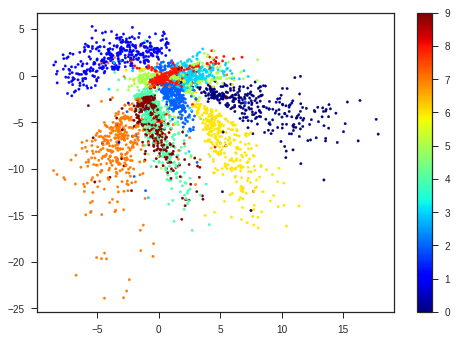

In [8]:
#fig, axes = plt.subplots(2,2, figsize = (6,6))
plot_bottleneck(cb = True)
#plot_bottleneck(ax = axes[0,1], Model = AENPModel5_ExactLsq_BPAuto, model_name = 'nodepert_ae5_bp_convparams')
#plot_bottleneck(ax = axes[1,0], Model = AENPModel5_ExactLsq_FAAuto, model_name = 'nodepert_ae5_fa_convparams')
#plot_bottleneck(ax = axes[1,1], Model = AENPModel5, model_name = 'nodepert_ae5_sgd_convparams')
#axes[0,0].set_title('ADAM')
#axes[0,1].set_title('back propagation')
#axes[1,0].set_title('feedback alignment')
#axes[1,1].set_title('node perturbation')
#plt.savefig('./figures/fig_3_autoencoder_latent.png', dpi = 200)

## Example autoencoded images

In [9]:
def plot_encodedimages(Model = AENPModel5_ADAM, model_name = 'nodepert_ae5_adam', save = False):
    Data = MNISTDataGenerator
    Trainer = AESFTrainer
    config = process_config('./configs/np.json', model_name)
    tf.reset_default_graph()
    model = Model(config)
    data = Data(config)
    sess = tf.Session()
    logger = LoggerNumpy(sess, config, model)
    trainer = Trainer(sess, model, data, config, logger)
    model.load(sess)
    batch_x, batch_y = next(data.next_batch(config.batch_size))
    feed_dict = {model.x: batch_x, model.y: batch_x, model.is_training: True}
    in_images = np.reshape(batch_x[0:16,:].T, (28,28,16))
    images = sess.run(model.y_p, feed_dict=feed_dict).T
    images = np.reshape(images[:,0:16], (28,28, 16))
    print(in_images.shape)
    fig, axes = plt.subplots(4,4, figsize = (2,2))
    for idx in range(8):
        i = int(idx/4)
        j = idx%4
        print(idx, i, j)
        axes[i,j].imshow(np.squeeze(images[:,:,idx]))
        axes[2+i,j].imshow(np.squeeze(in_images[:,:,idx]))
        axes[i,j].axis('off')
        axes[2+i,j].axis('off')
    if save:
        plt.savefig('./figures/encoded_method_%s.png'%model_name)

Loading options for exp_name 'nodepert_ae5_adam'
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading model checkpoint ./experiments/nodepert_ae5_adam/checkpoint/-0 ...

INFO:tensorflow:Restoring parameters from ./experiments/nodepert_ae5_adam/checkpoint/-0
Model loaded
(28, 28, 16)
0 0 0
1 0 1
2 0 2
3 0 3
4 1 0
5 1 1
6 1 2
7 1 3
Loading options for exp_name 'nodepert_ae5_bp_convparams'
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading model checkpoint ./experiments/nodepert_ae5_bp_convparams/checkpoint/-0 ...

INFO:tensorflow:Restoring parameters from ./experiments/nodepert_ae5_bp_convparams/checkpoint/-0
Model loaded
(28, 28, 16)
0 0 0
1 0 1
2 0 2
3 0 3
4 1 0
5 1 1
6 1 2
7 1 3
Loading opt

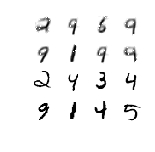

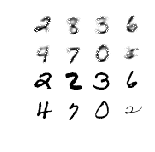

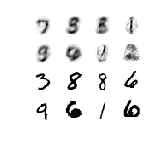

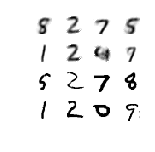

In [10]:
plot_encodedimages(save = True)
plot_encodedimages(Model = AENPModel5_ExactLsq_BPAuto, model_name = 'nodepert_ae5_bp_convparams',save = True)
plot_encodedimages(Model = AENPModel5_ExactLsq_FAAuto, model_name = 'nodepert_ae5_fa_convparams',save = True)
plot_encodedimages(Model = AENPModel5, model_name = 'nodepert_ae5_sgd_convparams',save = True)